In [1]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# 4.3 $\quad$ Modelo de mercado

Supongamos que el mercado está compuesto por de 500 títulos. Para estimar la cartera $M$ necesitamos la matriz de varianzas covarianzas es decir una matriz de 500x500= 250,000 celdas. Es decir, 500 varianzas y 124.750 covarianzas. Por ello, se propuso utilizar los indices de mercado como una proxy de la cartera $M$. Y estimar la beta mediante la siguiente regresión:  

$$\Large  R_{i,t} - R_f = \alpha_i + \beta_i (R_{Mt} - R_f) + \epsilon_{i,t} $$

$$\Large \pi_i=\alpha_i + \beta_i \pi_{Mt}+ \epsilon_{i,t}$$

donde:

- $ R_{it} $: Rendimiento del activo individual
- $ \alpha_i $: Alpha del activo
- $ \beta_i $: Beta del activo
- $ R_{mt} $: Rendimiento del indice de mercado
- $ \epsilon_i $: Término de error
- $ \pi_i = R_i - R_f $: Premio por riesgo

Veámoslo representado en la siguiente figura, donde se compara el activo `META` con el Nasdaq Composite Index (^IXIC). La imagen ha sido extraída del apéndice del capítulo **3.2. Conceptos Iniciales de Optimización**:

<img src="../imgs/capm_ejemplo.jpg">

- La recta naranja (el modelo) define la relación "promedio" entre el activo y el mercado.

- Los puntos azules representan el comportamiento del activo frente al mercado. Cuando los puntos azules están por encima de la recta, el activo ha ofrecido una rentabilidad superior a la media y cuanto está por debajo inferior a la media.

- Los puntos azules están más o menos "pegados" a la recta naranja según el caso. Cuando los puntos están más pegados, significa que el modelo expica mejor el comportamiento del título y el error cometido es menor. En el caso contrario, cuando los puntos están más alejados, significa que el modelo se está aproximando peor, es decir, el error cometido es mayor.

La estimación del modelo exige que se cumplan un conjunto de hipótesis:
1. $E(\varepsilon_{it})=0$
2. $\sigma^2(\varepsilon_{it})=\sigma^2_i, \forall t$
3. $cov(\varepsilon_{it},r_{it})=0,\forall t$
4. $cov(\varepsilon_{it},\varepsilon_{it'})=0, \forall t\neq t'$
5. $cov(\varepsilon_{it},\varepsilon_{jt})=0, \forall i\neq j$
6. $N[0,\sigma^2_\varepsilon ]$

## 1. Análisis de Rendimiento de una empresa, cartera o fondo: Alpha y Beta

- $\alpha_i$ es la parte del rendimiento del activo que es constante en el tiempo y que no depende del riesgo sistemático.  
- $\beta_i$ la parte de la rentabilidad que depende del comportamiento del mercado, es por tanto el **riesgo sistemático**.
- $\varepsilon_{it}$ perturbación aleatoria del título, provocado por acontecimientos no predecibles, por tanto es una medida del **riesgo específico**.

### Interpretación del modelo a nivel empresa

**Beta** ($\beta_i$) define la pendiente del modelo. Es un indicador de cuánto del rendimiento del activo está correlacionado con el rendimiento del mercado.

- **Interpretación**:
  - **Beta > 1**: El activo amplifica el comportamiento del mercado, presenta un elevado nivel de riesgo sistemático, por tanto deberá ofrecer más rentabilidad que el mercado.
  - **Beta < 1**: El activo atenúa el comportamiento del mercado. Tiene un menor nivel de riesgo sistemático y por tanto deberán ofrecer menos rentabilidad que el mercado.
  - **Beta ≈ 1**: El activo se comporta como el mercado, debe ofrecer la rentabilidad del mercado. 

La **Beta** nos ayuda a entender qué parte del rendimiento del activo es atribuible a los movimientos del mercado. 

#### Factores que Influyen en el Valor de la Beta de Mercado de una Empresa

- **Tipo de Sector**: impacto del ciclo económico en el sector.

- **Diversificación de Productos**: Empresas con diversificación en productos o servicios tienden a tener betas más bajos.

- **Diversisificación Geográfica**: El impacto de la diversificación geográfica de la actividad sobre el riesgo sistemático no es obvia pues confluyen efectos contradictorios. Por una lado la diversificación geográfica de la actividad debe reducir el riesgo sistemática, pero dicho proceso exigen asumir nuevas fuentes de riesgo como el riesgo de tipo de cambio y el riesgo país, con un resultado incierto sobre la beta.

- **Estructura Financiera**: Mayor apalancamiento financiero (deuda) implica mayor beta.

**Alpha**

Si definimos el exceso de rentabilidad de una cartera $\pi_i=\mu_i-r_f$ el modelo de mercado propone:

$$\pi_i=\alpha_i+ \beta_i \pi_M$$

Si $\alpha_i \neq 0$ que por alguna razón al activo se le exige una rentabilidad por encima o por debajo de la que debería ofrecer en función de su nivel de riesgo sistemático. Esto cuestiona el CAPM y podría interpretarse de la siguiente manera:
- $\alpha_i <0$ el activo está sobrevalorado
- $\alpha_i >0$ el activo está infravalorado

#### El riesgo de un título

La volatilidad de una activo viene definida por la siguiente expresión:

$$\sigma^2(\pi_{it})=\sigma^2(\alpha_i+\beta_i \pi_{M,t}\varepsilon_{it})=$$
$$\beta_i^2\sigma^2(\pi_{Mt})+\sigma^2(\varepsilon_{it})$$

La primera parte de la ecuación representa el riesgo sistemático y la segunda el específico, pero recuerda que el mercado retribuye únicamente el riesgo sistemático.


## 2. Resultados del modelo con algunos activos

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm.auto import tqdm
import statsmodels.api as sm
import warnings
from datetime import datetime, timedelta

# print(plt.style.available) #list of available styles
#plt.style.use('ggplot')
# Configura el estilo de Seaborn para que los gráficos se vean más atractivos
sns.set(style="whitegrid")

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

### ANALIZAR ALGUNAS ACCIONES INDIVIDUALES

Vamos a analizar un activo empleando del modelo de mercado. Elegimos la acción de Endesa y como índice de mercado usamos el IBEX35:

In [3]:
precios_endesa = yf.download("ELE.MC", start="2000-01-01", end="2023-11-30")["Adj Close"] # Precios ajustados al cierre
precios_endesa = precios_endesa.dropna() # Eliminar filas con NA's
rendimientos_endesa = np.log(precios_endesa).diff().dropna()

precios_ibex35 = yf.download("^IBEX", start="2000-01-01", end="2023-11-30")["Adj Close"] # Precios ajustados al cierre
precios_ibex35 = precios_ibex35.dropna() # Eliminar filas con NA's
rendimientos_ibex35 = np.log(precios_ibex35).diff().dropna()


[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[*********************100%%**********************]  1 of 1 completed


In [5]:
X = rendimientos_ibex35 # Rendimientos del mercado
y = rendimientos_endesa # Rendimientos del activo
X_sm = sm.add_constant(X)  # Añadir una constante a la variable X

# Crear y ajustar el modelo
modelo = sm.OLS(y, X_sm).fit()

ValueError: The indices for endog and exog are not aligned

In [6]:
rendimientos_ibex35.shape, rendimientos_endesa.shape

((6081,), (6014,))

In [7]:
# Índices del DataFrame rendimientos_ibex35
indices_ibex35 = set(rendimientos_ibex35.index)

# Índices del DataFrame rendimientos_endesa
indices_endesa = set(rendimientos_endesa.index)

# Valores en rendimientos_ibex35 que no están en rendimientos_endesa
unicos_ibex35 = indices_ibex35.difference(indices_endesa)

# Valores en rendimientos_endesa que no están en rendimientos_ibex35
unicos_endesa = indices_endesa.difference(indices_ibex35)

# Ahora unicos_ibex35 y unicos_endesa contienen los índices únicos de cada DataFrame
print("Únicos en IBEX35:", unicos_ibex35)
print("Únicos en Endesa:", unicos_endesa)


Únicos en IBEX35: {Timestamp('2000-01-24 00:00:00'), Timestamp('2000-05-23 00:00:00'), Timestamp('2000-06-29 00:00:00'), Timestamp('2000-03-23 00:00:00'), Timestamp('2000-02-04 00:00:00'), Timestamp('2000-06-05 00:00:00'), Timestamp('2000-04-11 00:00:00'), Timestamp('2000-04-28 00:00:00'), Timestamp('2000-04-05 00:00:00'), Timestamp('2000-03-02 00:00:00'), Timestamp('2000-05-24 00:00:00'), Timestamp('2018-09-20 00:00:00'), Timestamp('2000-05-22 00:00:00'), Timestamp('2000-03-21 00:00:00'), Timestamp('2000-03-14 00:00:00'), Timestamp('2000-03-24 00:00:00'), Timestamp('2000-03-06 00:00:00'), Timestamp('2000-01-27 00:00:00'), Timestamp('2000-03-22 00:00:00'), Timestamp('2000-03-08 00:00:00'), Timestamp('2000-02-23 00:00:00'), Timestamp('2000-06-21 00:00:00'), Timestamp('2000-01-28 00:00:00'), Timestamp('2000-05-17 00:00:00'), Timestamp('2000-01-14 00:00:00'), Timestamp('2000-02-03 00:00:00'), Timestamp('2000-03-01 00:00:00'), Timestamp('2000-02-15 00:00:00'), Timestamp('2000-05-18 00:00:0

In [8]:
# Índices comunes en ambos DataFrames
indices_comunes = rendimientos_ibex35.index.intersection(rendimientos_endesa.index)

rendimientos_endesa = rendimientos_endesa.loc[indices_comunes]
rendimientos_ibex35 = rendimientos_ibex35.loc[indices_comunes]


In [9]:
X = rendimientos_ibex35 # Rendimientos del mercado
y = rendimientos_endesa # Rendimientos del activo
X_sm = sm.add_constant(X)  # Añadir una constante a la variable X

# Crear y ajustar el modelo
modelo = sm.OLS(y, X_sm).fit()

Una vez entrenado, el modelo contiene mucha información que puede verse en [resultados modelo OLS](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.html#statsmodels.regression.linear_model.OLSResults)

Para ver un listado de la información contenida podemos usar la **función dir()**:

In [10]:
atributos = dir(modelo)

# Filtrar para excluir los nombres que comienzan con '__' o por '_'
atributos_filtrados = [a for a in atributos if not a.startswith('__') and not a.startswith('_')]

# Ahora atributos_filtrados 
print(atributos_filtrados)

['HC0_se', 'HC1_se', 'HC2_se', 'HC3_se', 'aic', 'bic', 'bse', 'centered_tss', 'compare_f_test', 'compare_lm_test', 'compare_lr_test', 'condition_number', 'conf_int', 'conf_int_el', 'cov_HC0', 'cov_HC1', 'cov_HC2', 'cov_HC3', 'cov_kwds', 'cov_params', 'cov_type', 'df_model', 'df_resid', 'eigenvals', 'el_test', 'ess', 'f_pvalue', 'f_test', 'fittedvalues', 'fvalue', 'get_influence', 'get_prediction', 'get_robustcov_results', 'info_criteria', 'initialize', 'k_constant', 'llf', 'load', 'model', 'mse_model', 'mse_resid', 'mse_total', 'nobs', 'normalized_cov_params', 'outlier_test', 'params', 'predict', 'pvalues', 'remove_data', 'resid', 'resid_pearson', 'rsquared', 'rsquared_adj', 'save', 'scale', 'ssr', 'summary', 'summary2', 't_test', 't_test_pairwise', 'tvalues', 'uncentered_tss', 'use_t', 'wald_test', 'wald_test_terms', 'wresid']


Los valores más usados son:

In [11]:
coeficientes_endesa = modelo.params
pvalues_endesa = modelo.pvalues
rsquared_adj_endesa = modelo.rsquared_adj

print("Coeficientes:", coeficientes_endesa)
print("Valores P:", pvalues_endesa)
print("R-cuadrado ajustado:", rsquared_adj_endesa)

Coeficientes: const        0.000359
Adj Close    0.687630
dtype: float64
Valores P: const        0.026112
Adj Close    0.000000
dtype: float64
R-cuadrado ajustado: 0.3860897016638025


El modelo proporciona un summary que es muy útil para analizar los resultados:

In [12]:
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     3745.
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:15:33   Log-Likelihood:                 17673.
No. Observations:                5954   AIC:                        -3.534e+04
Df Residuals:                    5952   BIC:                        -3.533e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.225      0.0

Hay que realizar la interpretación tanto **estadística** como **económica** de los resultados de la regresión lineal:

1- ¿CÓMO SE INTERPRETAN LOS VALORES DEL SUMMARY?

2- ¿QUÉ EXPLICACIÓN ECONÓMICA TIENEN LOS VALORES DEL MODELO?

#### EJERCICIO:

Analizar las acciones de  Telefónica y Johnson & Johnson. Para Telefónoca usad el IBEX35 y en el caso de Johnson & Johnson utilizad los índice SP100 y el Dow Jones Industrial Average.

Utilizad el periodo entre 2000-01-01 y 2023-11-30

**Telefónica**

In [13]:
precios_tef = yf.download("TEF.MC", start="2000-01-01", end="2023-11-30")["Adj Close"] # Precios ajustados al cierre   
precios_tef = precios_tef.dropna() # Eliminar filas con NA's
rendimientos_tef = np.log(precios_tef).diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [14]:
rendimientos_tef.shape, rendimientos_ibex35.shape

((6144,), (5954,))

In [15]:
# Índices comunes en ambos DataFrames
indices_comunes = rendimientos_ibex35.index.intersection(rendimientos_tef.index)

rendimientos_tef = rendimientos_tef.loc[indices_comunes]
rendimientos_ibex35 = rendimientos_ibex35.loc[indices_comunes]

In [16]:
X = rendimientos_ibex35 # Rendimientos del mercado
y = rendimientos_tef # Rendimientos del activo
X_sm = sm.add_constant(X)  # Añadir una constante a la variable X

# Crear y ajustar el modelo
modelo = sm.OLS(y, X_sm).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     9718.
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:15:34   Log-Likelihood:                 18374.
No. Observations:                5954   AIC:                        -3.674e+04
Df Residuals:                    5952   BIC:                        -3.673e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.535e-05      0.000     -0.596      0.5

**Johnson & Johnson**

ÍNDICE SP100

In [17]:
precios_jnj = yf.download("JNJ", start="2000-01-01", end="2023-11-30")["Adj Close"] # Precios ajustados al cierre
rendimientos_jnj = np.log(precios_jnj).diff().dropna()

precios_sp100 = yf.download("^SP100", start="2000-01-01", end="2023-11-30")["Adj Close"] # Precios ajustados al cierre
rendimientos_sp100 = np.log(precios_sp100).diff().dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [18]:
indices_comunes = rendimientos_jnj.index.intersection(rendimientos_sp100.index)

rendimientos_jnj = rendimientos_jnj.loc[indices_comunes]
rendimientos_sp100 = rendimientos_sp100.loc[indices_comunes]


In [19]:
X = rendimientos_sp100 # Rendimientos del mercado
y = rendimientos_jnj # Rendimientos del activo
X_sm = sm.add_constant(X)  # Añadir una constante a la variable X

# Crear y ajustar el modelo
modelo = sm.OLS(y, X_sm).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     2520.
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:15:34   Log-Likelihood:                 19038.
No. Observations:                6015   AIC:                        -3.807e+04
Df Residuals:                    6013   BIC:                        -3.806e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.610      0.1

ÍNDICE Dow Jones Industrial Average

In [20]:
precios_dji = yf.download("^DJI", start="2000-01-01", end="2023-11-30")["Adj Close"] # Precios ajustados al cierre
rendimientos_dji = np.log(precios_dji).diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [21]:
indices_comunes = rendimientos_jnj.index.intersection(rendimientos_dji.index)

rendimientos_jnj = rendimientos_jnj.loc[indices_comunes]
rendimientos_dji = rendimientos_sp100.loc[indices_comunes]

In [22]:
X = rendimientos_dji # Rendimientos del mercado
y = rendimientos_jnj # Rendimientos del activo
X_sm = sm.add_constant(X)  # Añadir una constante a la variable X

# Crear y ajustar el modelo
modelo = sm.OLS(y, X_sm).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     2520.
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:15:34   Log-Likelihood:                 19038.
No. Observations:                6015   AIC:                        -3.807e+04
Df Residuals:                    6013   BIC:                        -3.806e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.610      0.1

¿QUÉ PASA SI USAMOS DISTINTOS INTERVALOS DE  TIEMPO?. 

**EJERCICIO:**

En el caso anterior de Endes, calcular las $\beta$ pero empleando datos primero semanales y luego anuales

SEMANAL:

In [23]:
precios_endesa_sem = precios_endesa.resample('W').last()
retornos_endesa_semana = np.log(precios_endesa_sem).diff().dropna()

precios_ibex35_sem = precios_ibex35.resample('W').last()
retornos_ibex35_semana = np.log(precios_ibex35_sem).diff().dropna()

/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
# Índices comunes en ambos DataFrames
indices_comunes = retornos_ibex35_semana.index.intersection(retornos_endesa_semana.index)

retornos_endesa_semana = retornos_endesa_semana.loc[indices_comunes]
retornos_ibex35_semana = retornos_ibex35_semana.loc[indices_comunes]

In [25]:
X = retornos_ibex35_semana # Rendimientos del mercado
y = retornos_endesa_semana # Rendimientos del activo
X_sm = sm.add_constant(X)  # Añadir una constante a la variable X

# Crear y ajustar el modelo
modelo = sm.OLS(y, X_sm).fit()

coeficientes_endesa_semana = modelo.params

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     798.5
Date:                Thu, 04 Apr 2024   Prob (F-statistic):          1.56e-135
Time:                        09:15:35   Log-Likelihood:                 2654.3
No. Observations:                1221   AIC:                            -5305.
Df Residuals:                    1219   BIC:                            -5294.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      2.089      0.0

ANUAL

In [26]:
precios_endesa_año = precios_endesa.resample('Y').last()
retornos_endesa_año = np.log(precios_endesa_año).diff().dropna()

precios_ibex35_año = precios_ibex35.resample('Y').last()
retornos_ibex35_año = np.log(precios_ibex35_año).diff().dropna()

X = retornos_endesa_año # Rendimientos del mercado
y = retornos_endesa_año # Rendimientos del activo
X_sm = sm.add_constant(X)  # Añadir una constante a la variable X

# Crear y ajustar el modelo
modelo = sm.OLS(y, X_sm).fit()

coeficientes_endesa_año = modelo.params

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.449e+32
Date:                Thu, 04 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:15:35   Log-Likelihood:                 819.63
No. Observations:                  23   AIC:                            -1635.
Df Residuals:                      21   BIC:                            -1633.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.382e-17   1.94e-17      0.713      0.4

In [27]:
print("Beta con datos diarios (Endesa):", coeficientes_endesa[1])
print("Beta con datos semanales (Endesa):", coeficientes_endesa_semana[1])
print("Beta con datos anuales (Endesa):", coeficientes_endesa_año[1])

Beta con datos diarios (Endesa): 0.6876302973121572
Beta con datos semanales (Endesa): 0.715529993764702
Beta con datos anuales (Endesa): 0.9999999999999997


#### Varios activos americanos

Vamos a descargar algunos activos y los vamos a comparar con el índice `S&P 500`, que vamos a considerar como índice representativo del mercado.

In [28]:
tickers = [
    "AAPL",  # Apple Inc.
    "WFC",   # Wells Fargo & Co
    "XOM",   # Exxon Mobil Corp
    "JNJ",   # Johnson & Johnson
    "SBUX",  # Starbucks Corp
    "GLD" # ETF de oro
]

# Diccionario con tickers, nombres de empresas y sectores
empresas_dict = {
    "AAPL": {"nombre": "Apple Inc.", "sector": "Tecnología / Electrónica de Consumo", "alcance": "Global"},
    "WFC": {"nombre": "Wells Fargo & Co", "sector": "Servicios Financieros / Bancario", "alcance": "Local"},
    "XOM": {"nombre": "Exxon Mobil Corp", "sector": "Petróleo y Gas", "alcance": "Global"},
    "JNJ": {"nombre": "Johnson & Johnson", "sector": "Farmacéutica y Productos de Consumo", "alcance": "Global/Local"},
    "SBUX": {"nombre": "Starbucks Corp", "sector": "Alimentación y Bebidas / Servicio de Cafeterías", "alcance": "Local"},
    "GLD": {"nombre": "SPDR Gold Shares (GLD)", "sector": "", "alcance": ""}
}


In [29]:
precios = yf.download(tickers, start="2018-01-01", end="2023-11-30")["Adj Close"] # Precios ajustados al cierre
indice = yf.download("SPY", start="2018-01-01", end="2023-11-30")[["Adj Close"]] # Precios ajustados al cierre
precios = precios.dropna() # Eliminar filas con NA's
indice = indice.dropna() # Eliminar filas con NA's
indice.columns = ["MERCADO"] # Renombrar columna

# Calcular rendimientos logarítmicos
rendimientos = np.log(precios / precios.shift(1)).dropna()

rent_indice = np.log(indice / indice.shift(1)).dropna()


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed


In [30]:
def calc_regresion(r_ind, r):
    res = []
    summary = []
    
    for activo in r.columns:
        X = r_ind
        y = r[activo]
        X_sm = sm.add_constant(X)
        
        modelo = sm.OLS(y, X_sm).fit()
        
        resultado = {
        'activo': activo,
        'alpha': modelo.params[0],
        'beta': modelo.params[1],
        'p_value_alpha': modelo.pvalues[0],
        'p_value_beta': modelo.pvalues[1],
        't_value_alpha': modelo.tvalues[0],
        't_value_beta': modelo.tvalues[1],
        'rsquared': modelo.rsquared,
        'fvalue': modelo.fvalue,
        'conf_int_alpha_low': modelo.conf_int()[0][0],
        'conf_int_alpha_high': modelo.conf_int()[0][1],
        'conf_int_beta_low': modelo.conf_int()[1][0],
        'conf_int_beta_high': modelo.conf_int()[1][1],
        'aic': modelo.aic,
        'bic': modelo.bic
        }
        
        res.append(resultado)
        summary.append(modelo.summary())
        
    df_resul = pd.DataFrame(res)
    df_resul = df_resul.set_index('activo')
    
    df_summ = pd.DataFrame(summary)
    df_summ.index = r.columns
    
    return df_resul, df_summ

Calculemos el $R^2$, $\alpha$ y $\beta$ para cada activo:

In [31]:
df_resul, df_summary = calc_regresion(rent_indice, rendimientos)

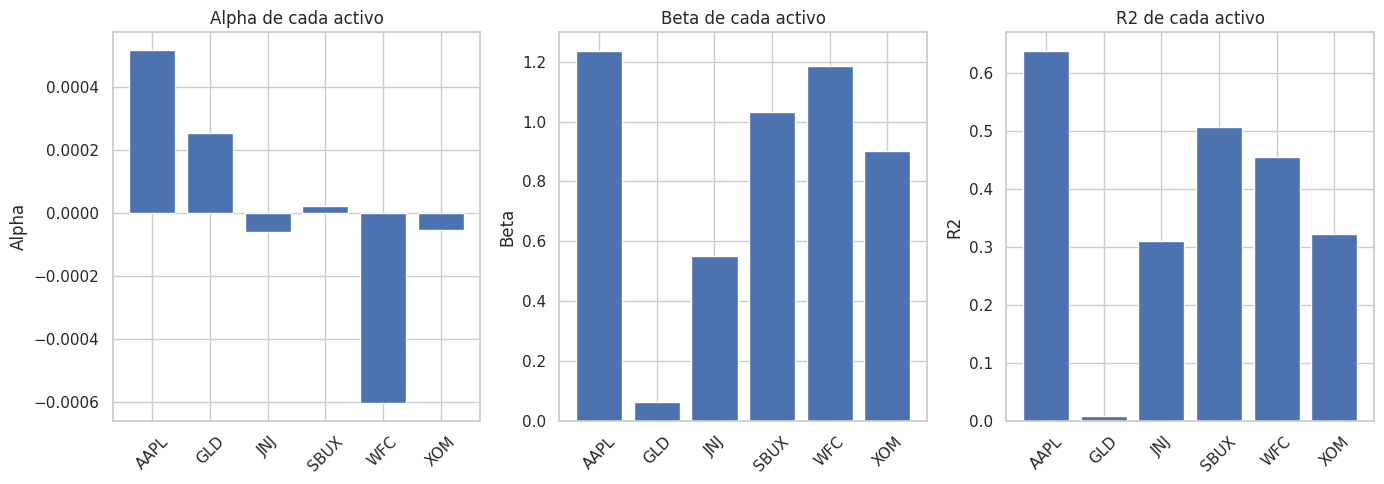

In [32]:

# Configura el tamaño de la figura y el número de subplots
fig, axs = plt.subplots(1,3, figsize=(14, 5))

# Primera gráfica: Alphas
axs[0].bar(df_resul.index, df_resul['alpha'])
axs[0].set_title('Alpha de cada activo')
axs[0].set_ylabel('Alpha')
axs[0].tick_params(axis='x', rotation=45)  # Rota las etiquetas del eje X si son demasiado largas

# Segunda gráfica: Betas
axs[1].bar(df_resul.index, df_resul['beta'])
axs[1].set_title('Beta de cada activo')
axs[1].set_ylabel('Beta')
axs[1].tick_params(axis='x', rotation=45)  # Rota las etiquetas del eje X si son demasiado largas

# Segunda gráfica: R2
axs[2].bar(df_resul.index, df_resul['rsquared'])
axs[2].set_title('R2 de cada activo')
axs[2].set_ylabel('R2')
axs[2].tick_params(axis='x', rotation=45)  # Rota las etiquetas del eje X si son demasiado largas

# Ajustar el layout para evitar la superposición de elementos
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [33]:
df_resul.loc[['AAPL', 'WFC', 'XOM', 'JNJ', 'SBUX', 'GLD'], ['beta', 'p_value_beta', 't_value_beta']]

,beta,p_value_beta,t_value_beta
activo,,,
AAPL,1.237180,0.000000e+00,51.176780
WFC,1.184850,1.358324e-197,35.165779
XOM,0.901047,4.441664e-127,26.505988
JNJ,0.550291,4.450535e-122,25.864108
SBUX,1.031838,3.945208e-230,39.055855
GLD,0.062931,4.239186e-04,3.532709


In [34]:
df_resul.loc[['AAPL', 'WFC', 'XOM', 'JNJ', 'SBUX', 'GLD'], ['alpha', 'p_value_alpha', 't_value_alpha']]

,alpha,p_value_alpha,t_value_alpha
activo,,,
AAPL,0.000516,0.099960,1.646075
WFC,-0.000602,0.168534,-1.377600
XOM,-0.000053,0.904318,-0.120229
JNJ,-0.000062,0.823130,-0.223560
SBUX,0.000020,0.952473,0.059611
GLD,0.000253,0.273946,1.094424


## 3. Todos los activos del SP500

In [35]:
precios_sp500 = pd.read_csv("../data/sp500_precios.csv", index_col=0, parse_dates=True)
precios_sp500.head(5)

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,63.381710,31.963160,37.893341,70.646538,63.908173,26.190001,131.077469,224.570007,78.138260,35.836353,...,41.850040,53.962513,35.926987,62.568439,83.576164,95.619514,156.240005,35.226196,81.659958,230.557449
2019-01-03,61.046745,29.581663,34.118874,68.318840,60.892082,25.780001,126.602242,215.699997,73.418312,35.678822,...,41.685143,53.133984,35.945953,60.423553,81.473938,93.889969,146.880005,35.031338,78.837448,225.055740
2019-01-04,63.159786,31.530161,35.575378,70.519852,62.630009,26.389999,131.524994,226.190002,75.200783,36.501442,...,42.093063,55.093021,36.988953,62.972939,83.594421,97.096619,152.970001,36.107277,81.930641,232.594147
2019-01-07,64.500923,32.425674,35.496204,71.549126,63.567928,26.330000,131.981812,229.259995,75.673691,36.685211,...,41.910801,55.379513,37.652691,62.041607,83.503029,97.134010,155.289993,36.251289,82.423607,234.428024
2019-01-08,65.446503,31.904114,36.172874,71.881653,62.804718,26.430000,135.319580,232.679993,77.519836,37.367813,...,42.396820,55.782177,37.396687,62.624863,83.338516,94.955734,156.330002,36.581703,83.651207,236.630554


In [36]:
# Calcular rendimientos logarítmicos
rendimientos_sp500 = np.log(precios_sp500).diff().dropna()

In [37]:
start_date = precios_sp500.index[0].date()
end_date = precios_sp500.index[-1].date()+ timedelta(days=1)

indice = yf.download("SPY", start=start_date, end=end_date)[["Adj Close"]] # Precios ajustados al cierre

rent_indice_sp500 = np.log(indice).diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [38]:
df_resul_SP500, df_summary_SP500 = calc_regresion(rent_indice_sp500, rendimientos_sp500)

In [39]:
beta_sig = 100 * (df_resul_SP500['p_value_beta']>0.05).sum()/len(df_resul_SP500)
alpha_sig = 100 * (df_resul_SP500['p_value_alpha']>0.05).sum()/len(df_resul_SP500)

print(f"El {beta_sig:.2f}% de los betas no son significativos")

print(f"El {alpha_sig:.2f}% de los alphas no son significativos")

El 0.00% de los betas no son significativos
El 99.18% de los alphas no son significativos


In [40]:
beta_mayor_1 = 100 * (df_resul_SP500['beta']>1).sum()/len(df_resul_SP500)

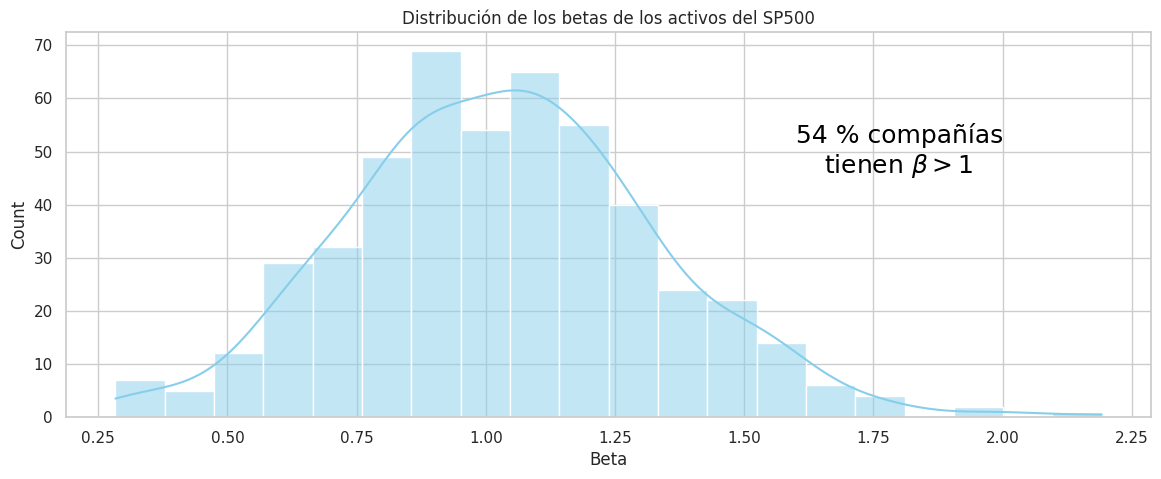

In [41]:
# Configura el estilo de Seaborn para que los gráficos se vean más atractivos
sns.set(style="whitegrid")

# Configura el tamaño de la figura y el número de subplots (1 fila, 2 columnas)
fig, axs = plt.subplots(figsize=(14, 5))

# Histograma para Beta
sns.histplot(df_resul_SP500['beta'], ax=axs, color='skyblue', kde=True)
axs.set_title('Distribución de los betas de los activos del SP500')
axs.set_xlabel('Beta')
#axs[0].set_ylabel('Frecuencia')

# Añade una nota en la gráfica de la izquierda
nota = f"{int(beta_mayor_1)} % compañías\ntienen $\\beta > 1$"
axs.text(1.8, 50, nota, ha='center', va='center', fontsize=18, color='black')



# Mostrar la gráfica
plt.show()


In [42]:
# Veamos los activos con alpha significativo
df_resul_SP500[(df_resul_SP500['p_value_alpha']<0.05)]

,alpha,beta,p_value_alpha,p_value_beta,t_value_alpha,t_value_beta,rsquared,fvalue,conf_int_alpha_low,conf_int_alpha_high,conf_int_beta_low,conf_int_beta_high,aic,bic
activo,,,,,,,,,,,,,,
LLY,0.000986,0.642527,0.043651,2.113457e-61,2.019469,17.479567,0.195789,305.535256,0.000028,0.570411,0.001945,0.714642,-6629.995111,-6619.722145
PWR,0.000965,1.076068,0.045810,1.088359e-146,1.999127,29.626473,0.411552,877.727882,0.000018,1.004811,0.001912,1.147324,-6660.100892,-6649.827926
VFC,-0.001592,1.244189,0.012658,4.671186e-119,-2.496824,25.929347,0.348840,672.331028,-0.002843,1.150052,-0.000341,1.338326,-5960.043594,-5949.770628
WBA,-0.001051,0.814386,0.048026,4.986958e-80,-1.979070,20.386602,0.248779,415.613551,-0.002092,0.736016,-0.000009,0.892757,-6420.876587,-6410.603621
